# Feature Selection

- **Low variance feature:** this type of eature are close to being constant; Scikit-learn has an
implementation for **VarianceThreshold** that does precisely this.

In [ ]:
from sklearn.feature_selection import VarianceThreshold
data = ...
var_thresh = VarianceThreshold(threshold=0.1)
transformed_data = var_thresh.fit_transform(data)
# transformed data will have all columns with variance less
# than 0.1 removed

- **High correlation**: if we find features that are correlated with each other we can discard one of them. **Pearson Correlation**.

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

# fetch a regression dataset
data = fetch_california_housing()

X = data["data"]
y = data["target"]

col_names = data["feature_names"]

# convert to pandas dataframe
df = pd.DataFrame(X, columns=col_names)

# introduce a highly correlated column
df.loc[:, "MedInc_Sqrt"] = df.MedInc.apply(np.sqrt)

# get correlation matrix (pearson)
df.corr()

## Univariate Feature Selection

It consist to but a score of each feature against a given target.

The most popular methods for univariate feature selection:
- **Mutual information** 
- **ANOVA** 
- **F-test**
- **chi square**: only for data which is non-negative in nature. Useful for NLP when we have a bag of words or tf-idf based features. 

There are two ways of using these in scikit- learn.
- **SelectKBest**: It keeps the top-k scoring features
- **SelectPercentile**: It keeps the top features which are in a percentage specified by the user


In [ ]:
from sklearn.feature_selection import chi2, f_classif, f_regression
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

class UnivariateFeatureSelection:
    def __init__(self, n_features, problem_type, scoring):
        """
        Custom univariate feature selection wrapper on
        different univariate feature selection models from scikit-learn.
        :param n_features: SelectPercentile if float else SelectKBest
        :param problem_type: classification or regression
        :param scoring: scoring function, string
        """
        
        # for a given problem type, there are only
        # a few valid scoring methods
        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        else:
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression    
            }
        
        # raise exception if we do not have a valid scoring method
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")
        
        # if n_features is int, we use selectkbest
        # if n_features is float, we use selectpercentile
        # please note that it is int in both cases in sklearn
        if isinstance(n_features, int):
            self.selection = SelectKBest(valid_scoring[scoring],
                                        k=n_features)
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(valid_scoring[scoring],
                                              percentile=int(n_features * 100))
        else:
            raise Exception("Invalid type of feature")

    # same fit function
    def fit(self, X, y):
        return self.selection.fit(X, y)

    # same transform function
    def transform(self, X):
        return self.selection.transform(X)

    # same fit_transform function
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)

In [ ]:
ufs = UnivariateFeatureSelection(n_features=0.1,
                                 problem_type="regression",
                                 scoring ="f_regression"
                                )
ufs.fit(X,y)
X_transformed = ufs.trasform(X)

## Feature Selection using Machine Learning

Univariate feature selection may not always perform
well. Most of the time, people prefer doing feature selection using a machine learning model.

### Greddy Feature Selection

- 1rst: choose a model
- 2nd: select a loss/scoring function
- 3rd: iteratively evaluate each feature and add it to the list of “good” features if it improves loss/score

**Cons:**

- the computational cost is very high.
- take a lot of time for this kind of feature selection to finish. 
- maybe it end up overfitting the model.


In [ ]:
# greedy.py
import pandas as pd

from sklearn import linear_model, metrics
from sklearn.datasets import make_classification

In [ ]:
class GreddyFeatureSelection:
    """
    A simple and custom class for greedy feature selection.
    You will need to modify it quite a bit to make it suitable
    for your dataset.
    """
    
    def evaluate_score(self, X, y):
        """
        This function evaluates model on data and returns
        Area Under ROC Curve (AUC)
        NOTE: We fit the data and calculate AUC on same data.
        WE ARE OVERFITTING HERE.
        But this is also a way to achieve greedy selection.
        k-fold will take k times longer.
        If you want to implement it in really correct way,
        calculate OOF AUC and return mean AUC over k folds.
        This requires only a few lines of change and has been
        shown a few times in this book.
        :param X: training data
        :param y: targets
        :return: overfitted area under the roc curve
        """
        # fit the logistic regression model,
        # and calculate AUC on same data
        # again: BEWARE
        # you can choose any model that suits your data
        model = linear_model.LogisticRegression()
        model.fit(X, y)
        predictions = model.predict_proba(X)[:, 1]
        auc = metrics.roc_auc_score(y, predictions)
        return auc

    def _feature_selection(self, X, y):
        """
        This function does the actual greedy selection
        :param X: data, numpy array
        :param y: targets, numpy array
        :return: (best_scores, best_features)
        """
        # initialize good features list
        # and best scores to keep track of both
        good_features = []
        best_scores = []
        
        # calculate the number of features
        num_features = X.shape[1]
        
        # infinite loop
        while True:
            # initialize best feature and score of this loop
            this_feature = None
            best_score = 0

            # loop over all features
            for feature in range(num_features):
                # if feature is already in good features,
                # skip this for loop
                if feature in good_features:
                    continue

                # selected features are all good features till now
                # and current feature
                selected_features = good_features + [feature]

                # remove all other features from data
                xtrain = X[:, selected_features]

                # calculate the score, in our case, AUC
                score = self.evaluate_score(xtrain, y)

                # if score is greater than the best score
                # of this loop, change best score and best feature
                if score > best_score:
                    this_feature = feature
                    best_score = score

            # if we have selected a feature, add it
            # to the good feature list and update best scores list
            if this_feature != None:
                good_features.append(this_feature)
                best_scores.append(best_score)

            # if we didnt improve during the last two rounds,
            # exit the while loop
            if len(best_scores) > 2:
                if best_scores[-1] < best_scores[-2]:
                        break

        # return best scores and good features
        # why do we remove the last data point?
        return best_scores[:-1], good_features[:-1]
        

if __name__ == "__main__":
    # generate binary classification data
    X, y = make_classification(n_samples=1000, n_features=100)
    # transform data by greedy feature selection
    X_transformed, scores = GreedyFeatureSelection()(X, y)

### Recursive Feature Elimination

In RFE, we start with all features and keep removing one feature in every iteration that
provides the least value to a given model.

To know what feature that gives the least value we can **analyse the coeficients** of our **SVM or 
logistic regression model.**

In case of any **tree-based models**, we get feature
importance in place of coefficients. In each iteration, we can eliminate the least important feature
and keep eliminating it until we reach the number of features
needed.

In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

# fetch a regression dataset
data = fetch_california_housing()

col_names = data["feature_names"]
X = data["data"]
y = data["target"]

# initialize the model
model = LinearRegression()

# initialize RFE
rfe = RFE(estimator=model,
          n_features_to_select=3)

# fit RFE
rfe.fit(X, y)

# get the transformed data with
# selected columns
X_transformed = rfe.transform(X)

### Feature Coefficients or the Importance of Features

Select features from the model. We can use a threshold on model coefficients to select features.

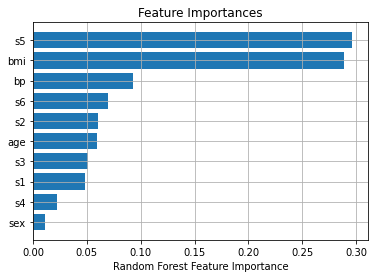

In [4]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = RandomForestRegressor()

# fit the model
model.fit(X, y)

importances = model.feature_importances_
idxs = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.grid()
plt.show()

### Chosse features using one model to use in another model

For example, 
- use Logistic Regression coefficients to select the features 
- and then use Random Forest to train the model on chosen features. 

Scikit-learn also offers SelectFromModel class that helps you choose features directly from a given model. 
You can also specify the threshold for coefficients or feature importance if you want and the
maximum number of features you want to select.

In [6]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = RandomForestRegressor()

# select from the model
sfm = SelectFromModel(estimator=model)
X_transformed = sfm.fit_transform(X, y)

# see which features were selected
support = sfm.get_support()

# get feature names
print([x for x, y in zip(col_names, support) if y == True])

['bmi', 's5']


The results are the most important features that were find in previous example. Thus, we could have also selected directly from feature importance provided by random forest.

**Note:** All tree-based models provide feature importance and thus they can be used, for example:
- XGBoost,
- LightGBM 
- CatBoost. 

But using differnt models we can obtain different feature importance function.  
In the end, we need to analyse if the features selected making sense for the problem that we are solving.

### L1 Lasso penalization

In L1 penalization for regularization, we can select the non-zero coefficients. 
Using the same code above is just replacing
random forest in the snippet of selection from a model with a model that supports
L1 penalty, e.g. lasso regression.

**Final note:**
Select features on training data and validate the model on validation data for proper selection of
features without overfitting the model.